# **Data preprocessing**

In [1]:
import pandas as pd

# Load the CSV file to check the structure and content
file_path = 'all_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Date,crude_oil_Price,crude_oil_Open,crude_oil_High,crude_oil_Low,crude_oil_Vol.,crude_oil_Change %,gold_Open,gold_High,gold_Low,...,silver_Change %,dollar_rate_Price,dollar_rate_Open,dollar_rate_High,dollar_rate_Low,dollar_rate_Change %,cpi_CPI,ppi_PPI,m1sl_M1SL,is_holiday
0,2014-01-01,98.70,98.61,98.76,98.54,NaN,0.28,NaN,NaN,NaN,...,NaN,80.03,80.21,80.24,80.10,0.00,234.1,201.2,2638.8,1
1,2014-01-02,95.44,98.50,98.97,95.34,251250.0,-3.30,117.930000,118.730003,117.750000,...,3.91,80.63,80.12,80.71,80.08,0.75,234.1,201.2,2638.8,0
2,2014-01-03,93.96,95.47,95.74,93.86,215520.0,-1.55,118.639999,119.620003,118.589996,...,0.41,80.79,80.57,80.89,80.49,0.20,234.1,201.2,2638.8,0
3,2014-01-06,93.43,94.18,94.59,93.20,189380.0,-0.56,119.760002,120.389999,117.110001,...,-0.53,80.65,80.86,80.91,80.54,-0.17,234.1,201.2,2638.8,0
4,2014-01-07,93.67,93.60,94.22,93.35,177180.0,0.26,118.459999,118.919998,118.129997,...,-1.57,80.83,80.69,80.95,80.60,0.22,234.1,201.2,2638.8,0


In [2]:
# Convert the 'Date' column to datetime format and sort by date
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_values(by='Date')
data.head()

,crude_oil_Price,crude_oil_Open,crude_oil_High,crude_oil_Low,crude_oil_Vol.,crude_oil_Change %,gold_Open,gold_High,gold_Low,gold_Close,...,silver_Change %,dollar_rate_Price,dollar_rate_Open,dollar_rate_High,dollar_rate_Low,dollar_rate_Change %,cpi_CPI,ppi_PPI,m1sl_M1SL,is_holiday
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,98.61,98.76,98.54,NaN,0.28,NaN,NaN,NaN,NaN,...,NaN,80.03,80.21,80.24,80.10,0.00,234.1,201.2,2638.8,1
2014-01-02,95.44,98.50,98.97,95.34,251250.0,-3.30,117.930000,118.730003,117.750000,118.000000,...,3.91,80.63,80.12,80.71,80.08,0.75,234.1,201.2,2638.8,0
2014-01-03,93.96,95.47,95.74,93.86,215520.0,-1.55,118.639999,119.620003,118.589996,119.290001,...,0.41,80.79,80.57,80.89,80.49,0.20,234.1,201.2,2638.8,0
2014-01-06,93.43,94.18,94.59,93.20,189380.0,-0.56,119.760002,120.389999,117.110001,119.500000,...,-0.53,80.65,80.86,80.91,80.54,-0.17,234.1,201.2,2638.8,0
2014-01-07,93.67,93.60,94.22,93.35,177180.0,0.26,118.459999,118.919998,118.129997,118.820000,...,-1.57,80.83,80.69,80.95,80.60,0.22,234.1,201.2,2638.8,0


# **LSTM Predictions - 1,5 and 30 day ahead with sp500, Silver and previous GLD**

In [4]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow prints

predictions_ranges = [1, 5, 30]
for forecast_horizon in predictions_ranges:
    # Load data
    data = pd.read_csv('data.csv')
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data = data.sort_values(by='Date').dropna().reset_index(drop=True)

    # Split the data into training and test sets
    train_data = data[data['Date'] < '2022-06-01']
    test_data = data[data['Date'] >= '2022-06-01']

    # Drop 'Date' column for training and scaling
    train_values = train_data.drop(columns=['Date']).values
    test_values = test_data.drop(columns=['Date']).values

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_values)
    test_scaled = scaler.transform(test_values)

    # Prepare data for LSTM model
    def create_lstm_data(dataset, look_back=1):
        X, y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), :])
            y.append(dataset[i + look_back, 0])  # Predicting 'gold_Close'
        return np.array(X), np.array(y)

    look_back = 1
    X_train, y_train = create_lstm_data(train_scaled, look_back)

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

    # Predict in forecast_horizon increments
    predictions = []
    current_index = 0

    while current_index + forecast_horizon < len(test_scaled):
        # Prepare the current batch
        current_batch = test_scaled[current_index:current_index + look_back].reshape((1, look_back, 3))

        # Predict for the next forecast_horizon days
        forecast = []
        for i in range(forecast_horizon):
            pred = model.predict(current_batch, verbose=0)[0][0]  # Suppress verbose output
            forecast.append(pred)

            # Update the current batch by adding the prediction and keeping other features as is
            new_row = np.array([pred] + test_scaled[current_index + i + 1, 1:].tolist()).reshape(1, 1, 3)
            current_batch = np.append(current_batch[:, 1:, :], new_row, axis=1)

        # Save the forecast
        predictions.extend(forecast)

        # Move forward by forecast_horizon days
        current_index += forecast_horizon

    # Convert predictions to the original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(np.concatenate([predictions, test_scaled[:len(predictions), 1:]], axis=1))[:, 0]

    # Get actual values for comparison
    actual_gld_close = test_data['gold_Close'].values[:len(predictions)]

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(test_data['Date'][:len(predictions)], actual_gld_close, label='Actual GLD Close')
    plt.plot(test_data['Date'][:len(predictions)], predictions, label='Predicted GLD Close')
    plt.xlabel('Date')
    plt.ylabel('GLD Close Price')
    plt.title(f'{forecast_horizon}-Day-Ahead GLD Close Price')
    plt.legend()
    plt.show()

    # Results
    # Calculate MSE
    mse = mean_squared_error(actual_gld_close, predictions)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate R^2 score
    r2 = r2_score(actual_gld_close, predictions)
    # Print results
    print(f"{forecast_horizon}-Day Ahead Forecast:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R^2 Score: {r2}")
    print("\n" + "="*50 + "\n")


ModuleNotFoundError: No module named 'tensorflow'

# **GLD prediction by LSTM trained on:**
['gold_Close', 'silver_Price', 'sp500_Price','gold_price_yesterday', 'gold_price_2days', 'gold_price_3days','cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price','is_holiday']

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


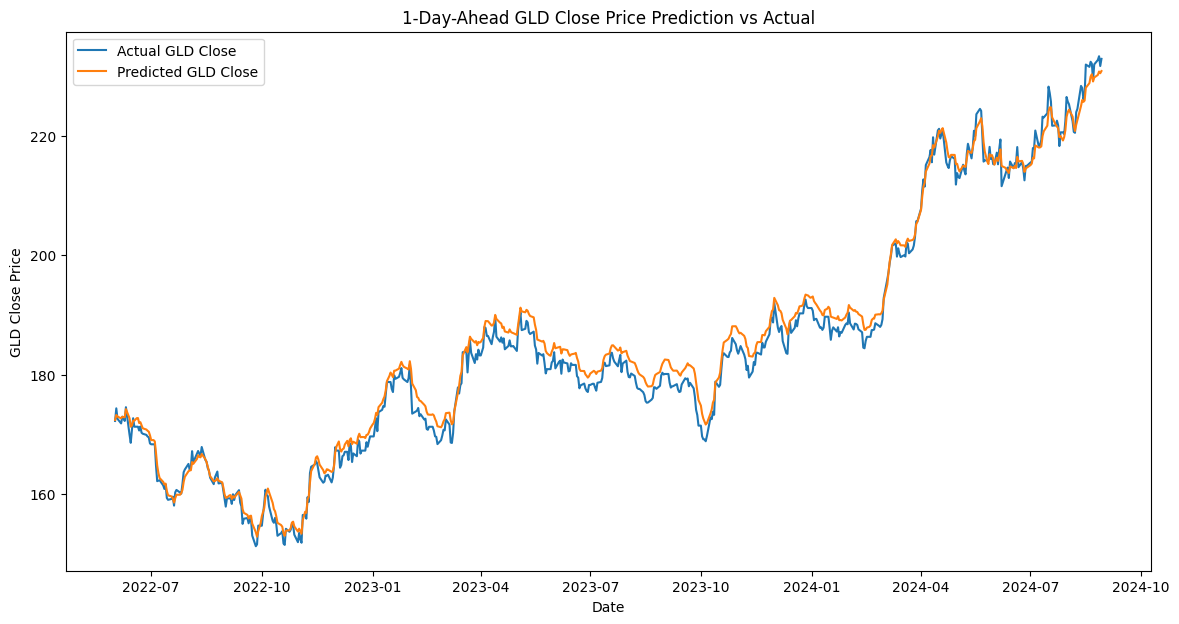

1-Day Ahead Forecast:
Mean Squared Error (MSE): 3.832539870702075
Root Mean Squared Error (RMSE): 1.957687378184289
R^2 Score: 0.9903849670544669



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


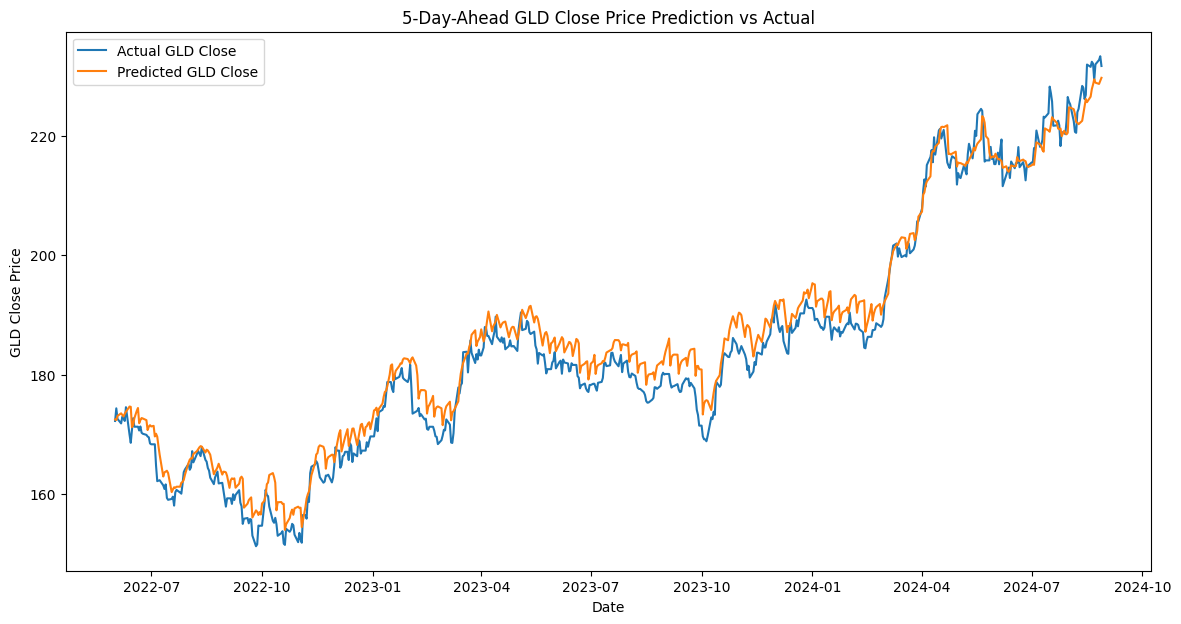

5-Day Ahead Forecast:
Mean Squared Error (MSE): 11.678284083270446
Root Mean Squared Error (RMSE): 3.4173504478280314
R^2 Score: 0.9704603463700804



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


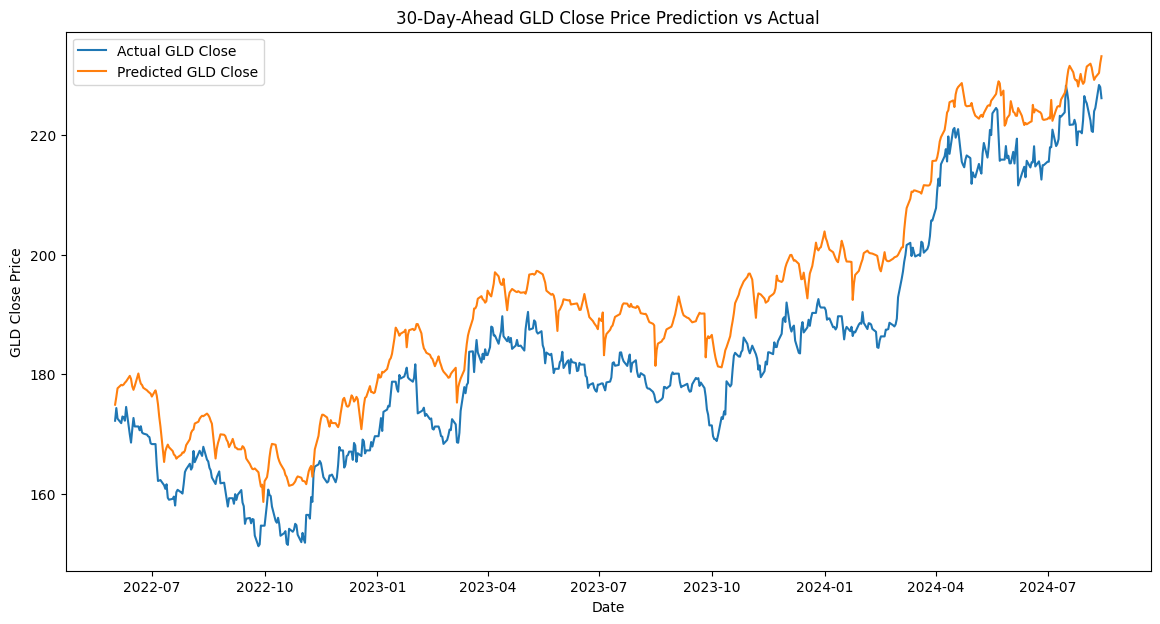

30-Day Ahead Forecast:
Mean Squared Error (MSE): 85.24528361233764
Root Mean Squared Error (RMSE): 9.232837246065678
R^2 Score: 0.7657210206409711



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import os

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Define forecast ranges
predictions_ranges = [1, 5, 30]

# Loop through each forecast range
for forecast_horizon in predictions_ranges:
    # Load data
    data = pd.read_csv('all_data.csv')
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
    data = data.sort_values(by='Date').dropna().reset_index(drop=True)

    # Create lagged gold price columns
    data['gold_price_yesterday'] = data['gold_Close'].shift(1)
    data['gold_price_2days'] = data['gold_Close'].shift(2)
    data['gold_price_3days'] = data['gold_Close'].shift(3)

    # Select required columns and drop rows with missing values
    selected_columns = [
        'Date', 'gold_Close', 'silver_Price', 'sp500_Price', 'gold_price_yesterday',
        'gold_price_2days', 'gold_price_3days', 'cpi_CPI', 'ppi_PPI',
        'm1sl_M1SL', 'dollar_rate_Price', 'is_holiday'
    ]
    filtered_data = data[selected_columns].dropna().reset_index(drop=True)

    # Split data into training and test sets
    train_data = filtered_data[filtered_data['Date'] < '2022-06-01']
    test_data = filtered_data[filtered_data['Date'] >= '2022-06-01']

    # Drop 'Date' column for training and scaling
    train_values = train_data.drop(columns=['Date']).values
    test_values = test_data.drop(columns=['Date']).values

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_values)
    test_scaled = scaler.transform(test_values)

    # Prepare data for LSTM model
    def create_lstm_data(dataset, look_back=1):
        X, y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), :])
            y.append(dataset[i + look_back, 0])  # Predicting 'gold_Close'
        return np.array(X), np.array(y)

    look_back = 1
    X_train, y_train = create_lstm_data(train_scaled, look_back)

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

    # Predict in forecast_horizon increments
    predictions = []
    current_index = 0

    while current_index + forecast_horizon < len(test_scaled):
        # Prepare the current batch
        current_batch = test_scaled[current_index:current_index + look_back].reshape((1, look_back, test_scaled.shape[1]))

        # Predict for the next forecast_horizon days
        forecast = []
        for i in range(forecast_horizon):
            pred = model.predict(current_batch, verbose=0)[0][0]
            forecast.append(pred)

            # Update the current batch by adding the prediction and keeping other features as is
            new_row = np.array([pred] + test_scaled[current_index + i + 1, 1:].tolist()).reshape(1, 1, test_scaled.shape[1])
            current_batch = np.append(current_batch[:, 1:, :], new_row, axis=1)

        # Save the forecast
        predictions.extend(forecast)

        # Move forward by forecast_horizon days
        current_index += forecast_horizon

    # Convert predictions to the original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(np.concatenate([predictions, test_scaled[:len(predictions), 1:]], axis=1))[:, 0]

    # Get actual values for comparison
    actual_gld_close = test_data['gold_Close'].values[:len(predictions)]

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(test_data['Date'][:len(predictions)], actual_gld_close, label='Actual GLD Close')
    plt.plot(test_data['Date'][:len(predictions)], predictions, label='Predicted GLD Close')
    plt.xlabel('Date')
    plt.ylabel('GLD Close Price')
    plt.title(f'{forecast_horizon}-Day-Ahead GLD Close Price Prediction vs Actual')
    plt.legend()
    plt.show()

    # Results
    # Calculate MSE
    mse = mean_squared_error(actual_gld_close, predictions)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate R^2 score
    r2 = r2_score(actual_gld_close, predictions)
    # Print results
    print(f"{forecast_horizon}-Day Ahead Forecast:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R^2 Score: {r2}")
    print("\n" + "="*50 + "\n")
